In [1]:
# Import Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
import yfinance as yf
import calendar
from datetime import datetime

# Import the API key
from api_keys import alpha_vantage_api_key, bls_api_key, fred_api_key
from fredapi import Fred # https://pypi.org/project/fredapi/  https://cran.r-project.org/web/packages/eFRED/vignettes/FetchingDataFromFRED.html

# Getting Daily stock close price compared to Monthly US CPI
Daily closing Stock price and US CPI (y-axis : scaling 0 ~ 1), Monthly (x-axis) for 10 years by line plot 

### Step 1: US CPI
Using "CUSR0000SEEB" on FRED as it seems pretty accurate

In [2]:
# FRED API url assembly
url = "https://api.stlouisfed.org/fred/series/observations"
params = {
    "series_id": "CUSR0000SEEB",  # Interest rate series ID
    "api_key": fred_api_key,  # Replace with your API key
    "file_type": "json",
    "observation_start": "2010-01-01", # Starting year of data gathering
    "observation_end": "2019-12-31" 
}
# Make the response, ensure that you've added your API key for FRED in the api_keys.py file else this request will not work
# Please also note that FRED has a limited number of requests per day so only run this cell a few times
response = requests.get(url, params=params)
CPI_Data = response.json()

### Step 2: Get stock data
Using Common_Module we import the stockdata dataframe

In [3]:
from Common_Module.Common_Stockdata import get_stock_data
stock = get_stock_data()
stock[["Date", "Close"]].sort_values(by=["Date"])

,Date,Close
3605,2010-01-04,46.42
3604,2010-01-05,46.42
3603,2010-01-06,46.14
3602,2010-01-07,46.17
3601,2010-01-08,46.55
...,...,...
1094,2019-12-24,211.92
1093,2019-12-26,213.79
1092,2019-12-27,213.61
1091,2019-12-30,212.21


### Step 3, turn into CPI Dataframe
Turn the raw json data from FRED into a Dataframe that can be organised easier

In [4]:
datatotal = 0
updated_date = []
updated_rate = [] # assigned variables outside forloop with empty variables ready to be appended
# For loop will take the date and rate from the json file for the 10 years requested and add the values to a new array
for observation in CPI_Data["observations"]:
    date = observation["date"]
    interest_rate = observation["value"]
    updated_date.append(date)
    updated_rate.append(interest_rate)
    datatotal = datatotal + 1

Monthly_CPI_df = pd.DataFrame({
    "Date" : updated_date,
    "CPI Price" : updated_rate
    })
Monthly_CPI_df.replace('.', pd.NA, inplace=True)  # Use pd.NA for missing values in newer versions of Pandas
Monthly_CPI_df.dropna(inplace=True) # Dropping any nulls based on '.'
Monthly_CPI_df.reset_index()
print()

### Step 4: Convert into one dataframe
Now we get both of these frames and combine them based on the DATE column

In [5]:
stock['Date'] = pd.to_datetime(stock['Date'])
Monthly_CPI_df['Date'] = pd.to_datetime(Monthly_CPI_df['Date'])

# Merge using pd.merge_asof()
merged_CPI_df = pd.merge_asof(stock.sort_values('Date'), Monthly_CPI_df, on='Date', direction='backward')

# Fill NaN values in CPI columns with the last valid observation
CPI_columns = [col for col in merged_CPI_df.columns if 'CPI' in col]
merged_CPI_df[CPI_columns] = merged_CPI_df[CPI_columns].fillna(method='ffill')

# Drop NaN values
merged_CPI_df.dropna(inplace=True)

C:\Users\baile\AppData\Local\Temp\ipykernel_9756\2547752691.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_CPI_df[CPI_columns] = merged_CPI_df[CPI_columns].fillna(method='ffill')


### Step 5: Dataframe organising 
Sort all the data and arrange it into lists and arrays to be used in the Line Graph

In [6]:
close_list = merged_CPI_df["Close"].tolist()
close_list_float = [float(val) for val in close_list]
close_array = np.array(close_list_float)

close_list_min = close_array.min()
close_list_max = close_array.max()

close_list_float_normalised = (close_array - close_list_min) / (close_list_max - close_list_min)
close_list_float_normalised

CPI_list = merged_CPI_df['CPI Price'].tolist()
CPI_list_float = [float(val) for val in CPI_list]
CPI_array = np.array(CPI_list_float)

CPI_list_min = CPI_array.min()
CPI_list_max = CPI_array.max()
CPI_list_float_normalised = (CPI_array - CPI_list_min) / (CPI_list_max - CPI_list_min)

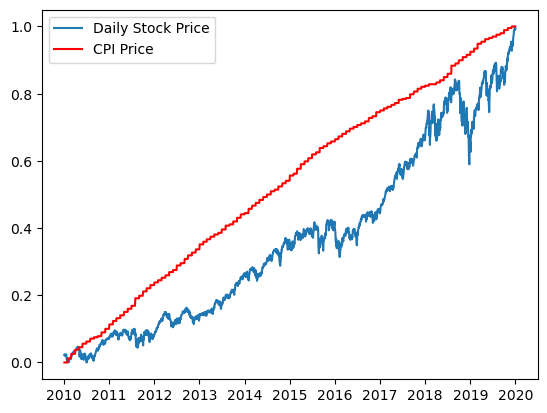

In [7]:
# Graphing the plot
plt.plot(merged_CPI_df['Date'], close_list_float_normalised, label='Daily Stock Price')
plt.plot(merged_CPI_df['Date'], CPI_list_float_normalised, label='CPI Price', color='red')
plt.legend()